<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/AirQuality122024_pm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# -- Load county shapefiles
dir = "/content/drive/MyDrive/Disertation/countyshp/"
county = gpd.read_file(dir + "tl_2010_us_county00/tl_2010_us_county00.shp")
county = county[["CNTYIDFP00", "geometry"]]

Mounted at /content/drive


#Defining Functions

In [2]:
def gen_GEOID(df):
  # generate GEOID
  df["GEOID"] = df["State Code"].astype(str).str.zfill(2) + df["County Code"].astype(str).str.zfill(3)
  df = df.drop(columns=["State Code", "County Code"])
  return df

def gen_year(df):
  # get year
  df["year"] = df["Date"].str[:4].astype(int)
  df = df.drop(columns="Date")
  return df

def grouping(df):
  df = df.groupby(["GEOID", "year", 'Units of Measure']).agg(["mean", "std", "max", "min"])
  # combining columns
  df.columns = ["_".join(col) for col in df.columns]
  df = df.reset_index()
  return df

def get_PM25(year):
  dir = "/content/drive/MyDrive/Disertation/EPA_data/PM25"
  fname = f"/daily_SPEC_{year}.csv"
  df = pd.read_csv(dir + fname, low_memory=False)
  df = df[["State Code", "County Code", "Date Local", "Arithmetic Mean", 'Units of Measure']]
  df.columns = ["State Code", "County Code", "Date", "PM2.5", 'Units of Measure']
  return df

def get_PM10(year):
  dir = "/content/drive/MyDrive/Disertation/EPA_data/PM10"
  fname = f"/daily_PM10SPEC_{year}.csv"
  df = pd.read_csv(dir + fname, low_memory=False)
  df = df[["State Code", "County Code", "Date Local", "Arithmetic Mean", 'Units of Measure']]
  df.columns = ["State Code", "County Code", "Date", "PM10", 'Units of Measure']
  return df



#Calculating Parameters

##PM2.5

In [ ]:
# -- Create pm25 dataframe
pm25 = pd.DataFrame()

for year in range(1998, 2023):
  df = grouping_pm25(gen_year(gen_GEOID(get_PM25(year))))
  pm25 = pd.concat([pm25, df]).reset_index().drop(columns="index")

# -- Merge pm25 and county
print(len(pm25))
pm25 = county.merge(pm25, right_on="GEOID", left_on="CNTYIDFP00", how="right")
pm25 = pm25.drop(columns="CNTYIDFP00")
print(len(pm25))

54148
54148


##PM10

In [3]:
# -- Create pm10 dataframe
pm10 = pd.DataFrame()

for year in range(1998, 2023):
  df = grouping(gen_year(gen_GEOID(get_PM10(year))))
  pm10 = pd.concat([pm10, df]).reset_index().drop(columns="index")

# -- Merge pm10 and county
print(len(pm10))
pm10 = county.merge(pm10, right_on="GEOID", left_on="CNTYIDFP00", how="right")
pm10 = pm10.drop(columns="CNTYIDFP00")
print(len(pm10))

14029
14029


In [6]:
pm10["Units of Measure"].unique()

array(['Micrograms/cubic meter (LC)', 'Micrograms/cubic meter (25 C)',
       'Nanograms/cubic meter (25 C)', 'Nanograms/cubic meter (LC)'],
      dtype=object)

In [ ]:
pm10 = pd.DataFrame()

for year in range(1998, 1999):
  df = get_PM10(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_LC_nano = df[df['Units of Measure'] == 'Nanograms/cubic meter (LC)'].copy()
  df_LC_micro = df[df['Units of Measure'] == 'Micrograms/cubic meter (LC)'].copy()
  df_25c_nano = df[df['Units of Measure'] == 'Nanograms/cubic meter (25 C)'].copy()
  df_25c_micro = df[df['Units of Measure'] == 'Micrograms/cubic meter (25 C)'].copy()
  # convert to micro
  df_LC_nano['PM10'] = df_LC_nano['PM10'].copy() * 0.001

  df_25c_nano['PM10'] = df_25c_nano['PM10'].copy() * 0.001


In [ ]:
  # combine
  df_LC = pd.concat([df_LC_micro, df_LC_nano])
  df_25c = pd.concat([df_25c_micro, df_25c_nano])
  df2 = pd.concat([df_LC, df_25c])
  df2 = df2.groupby(["GEOID", "year", 'Units of Measure']).agg(["mean", "std", "max", "min"])
  df2.columns = ["_".join(col) for col in df2.columns]
  pm10 = pd.concat([pm10, df2.reset_index()])

#Descriptive Statistics

In [ ]:
# Removing Non-contiguous counties
for i in ['02', '15', '60', '66', '69', '72', '78', "80"]:
  aqi = aqi[aqi.GEOID.str[:2] != i]
  co = co[co.GEOID.str[:2] != i]
  no2 = no2[no2.GEOID.str[:2] != i]
  ozone = ozone[ozone.GEOID.str[:2] != i]
  so2 = so2[so2.GEOID.str[:2] != i]
  pm25 = pm25[pm25.GEOID.str[:2] != i]
  pm10 = pm10[pm10.GEOID.str[:2] != i]

In [ ]:
# Save Everything
pm25.to_csv("/content/drive/MyDrive/Disertation/pm25.csv", index=False)
pm10.to_csv("/content/drive/MyDrive/Disertation/pm10.csv", index=False)

In [ ]:
# Import everything
pm25 = pd.read_csv("/content/drive/MyDrive/Disertation/pm25.csv")
print(f"PM2.5 imported ... {len(pm25)} entries")
pm10 = pd.read_csv("/content/drive/MyDrive/Disertation/pm10.csv")
print(f"PM10 imported ... {len(pm10)} entries")
print("......... Completed .........")

AQI imported ... 25785 entries
CO imported ... 5039 entries
NO2 imported ... 6238 entries
Ozone imported ... 18919 entries
SO2 imported ... 8039 entries
PM2.5 imported ... 14551 entries
PM10 imported ... 9943 entries
......... Completed .........


In [ ]:
# Potential Treatment Counties
treatments = ["25027","34003","13151","48329","27003","48135","42071","51107","42077","06065","34007"]

In [ ]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25.GEOID.unique():
  df = pm25[pm25.GEOID == i]
  ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.5, linewidth=0.5 )



ax.set_xlabel("Year")
ax.set_ylabel("Mean Value")

fig.show()

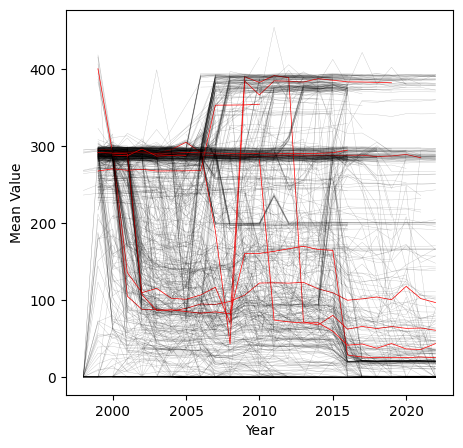

In [ ]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25.GEOID.unique():
  if i in treatments:
    df = pm25[pm25.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25[pm25.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )



ax.set_xlabel("Year")
ax.set_ylabel("Mean Value")

fig.show()

In [ ]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm10.GEOID.unique():
  df = pm10[pm10.GEOID == i]
  ax.plot(df.year, df.PM10_mean, color="black", alpha=0.5, linewidth=0.5 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value")

fig.show()

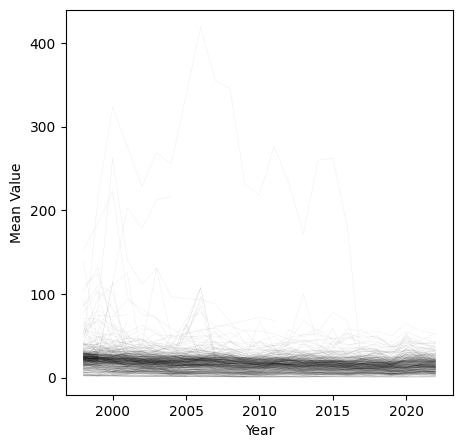

In [ ]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm10.GEOID.unique():
  if i in treatments:
    df = pm10[pm10.GEOID == i]
    ax.plot(df.year, df.PM10_mean, color="red", alpha=1, linewidth=1)
  else:
    df = pm10[pm10.GEOID == i]
    ax.plot(df.year, df.PM10_mean, color="black", alpha=0.1, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value")

fig.show()